In [54]:
import numpy as np
from numpy.linalg import inv

a = np.arange(80.).reshape(20,4)
b = np.arange(4.).reshape(1,4)
c = np.exp(np.tensordot(a,b.T, axes=(1))) / (1+np.exp(np.tensordot(a,b.T, axes=(1)))**2)
d = np.exp(np.tensordot(a,b.T, axes=(1))) / (1+np.exp(np.tensordot(a,b.T, axes=(1)))**2)
e = np.diag(d.flatten())
f = np.matmul(a.T, e)
g = np.matmul(f, a)
h = inv(g)
i = np.diag(h)
print(h)
print(np.sqrt(i))


[[-3.14824437e+21  4.72236883e+21  0.00000000e+00 -1.57412332e+21]
 [ 5.70619283e+21 -8.26414135e+21 -5.90295810e+20  3.14824432e+21]
 [-1.96765270e+21  2.36118324e+21  1.18059162e+21 -1.57412216e+21]
 [-5.90295810e+20  1.18059162e+21 -5.90295810e+20  6.55360000e+04]]
[           nan            nan 3.43597384e+10 2.56000000e+02]


/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_13538/2832506441.py:6: RuntimeWarning: overflow encountered in square
  c = np.exp(np.tensordot(a,b.T, axes=(1))) / (1+np.exp(np.tensordot(a,b.T, axes=(1)))**2)
/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_13538/2832506441.py:7: RuntimeWarning: overflow encountered in square
  d = np.exp(np.tensordot(a,b.T, axes=(1))) / (1+np.exp(np.tensordot(a,b.T, axes=(1)))**2)
/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_13538/2832506441.py:14: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(i))


In [56]:
unlearn_clients = np.arange(0, 10 )

In [57]:
print(unlearn_clients)

[0 1 2 3 4 5 6 7 8 9]


data/churnsimulateddata.csv


/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_13538/1605401485.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = 'High'


Labels counts after balancing.
1    21
0    21
Name: Churn_risk, dtype: int64
Traing size (42,)
Testing size (32,)
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END ..........................C=0.001;, score=1.000 total time=   0.0s
[CV 2/10] END ..........................C=0.001;, score=1.000 total time=   0.0s
[CV 3/10] END ..........................C=0.001;, score=0.667 total time=   0.0s
[CV 4/10] END ..........................C=0.001;, score=0.500 total time=   0.0s
[CV 5/10] END ..........................C=0.001;, score=1.000 total time=   0.0s
[CV 6/10] END ..........................C=0.001;, score=1.000 total time=   0.0s
[CV 7/10] END ..........................C=0.001;, score=0.667 total time=   0.0s
[CV 8/10] END ..........................C=0.001;, score=0.667 total time=   0.0s
[CV 9/10] END ..........................C=0.001;, score=1.000 total time=   0.0s
[CV 10/10] END .........................C=0.001;, score=1.000 total time=   0.0s
[CV 1/10] END 

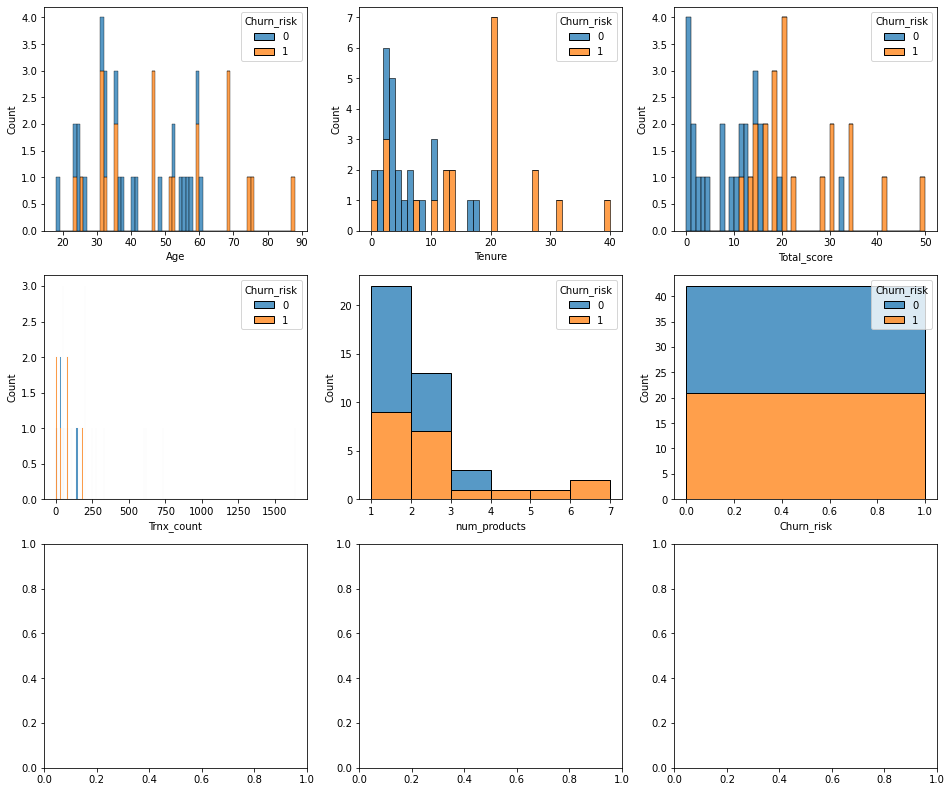

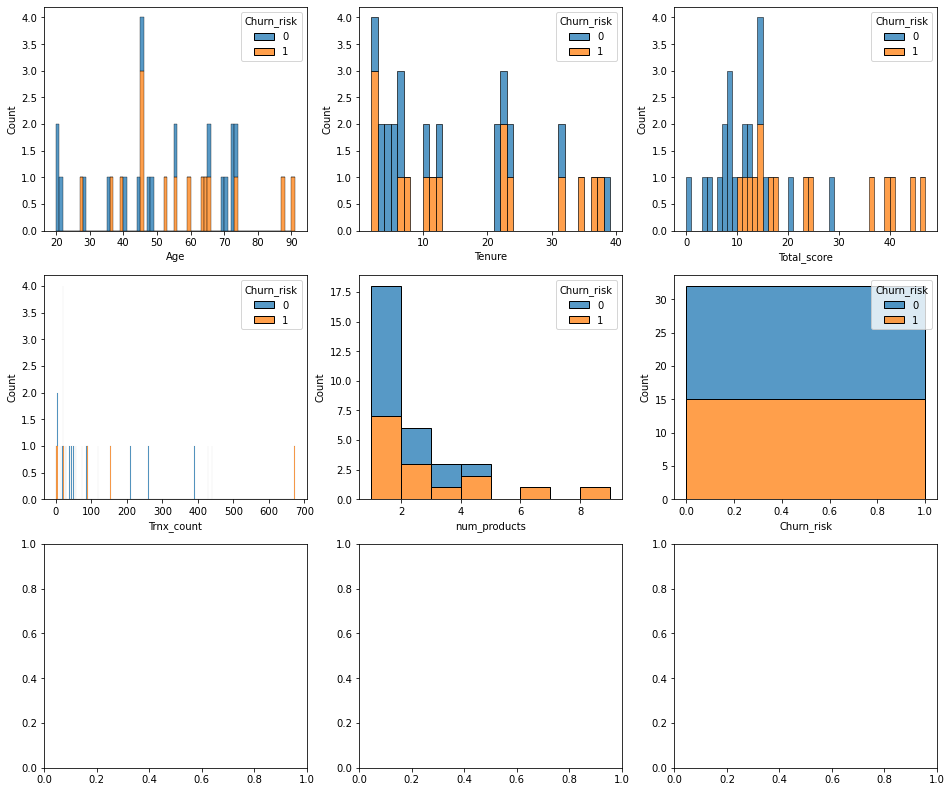

In [59]:
import os
import pandas as pd
import numpy as np
import timeit

import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns


def train_single_model(file_name):
    path = 'data'
    file_name = file_name
    file = os.path.join(path, file_name)
    print(file)
    # read data
    df = pd.read_csv(file)
    feature_names = ['Age','Tenure','PSYTE_Segment','Total_score','Trnx_count','num_products', 'Churn_risk']
    #feature_names = ['Age','Tenure','PSYTE_Segment','Trnx_count','num_products', 'Churn_risk']

    selected_df = df[feature_names].dropna()

    # binarize
    selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = 'High'  
    #selected_df = selected_df.drop(selected_df[selected_df['Churn_risk'] == 'Medium'].index) 
    

    selected_df['Churn_risk'] = selected_df.Churn_risk.astype("category").cat.codes
    client_data = selected_df.dropna()

    #for rat in range(100,1,-1):
    #data_s = data.sample(frac=0.01)
    #data_r = data_s.sample(frac=rat/100.)
    client_data = client_data.sample(frac=0.00011)
    X = client_data.drop(columns=['Churn_risk','PSYTE_Segment'])
    y = client_data['Churn_risk']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) 
    
    X = pd.concat([X_train, y_train], axis=1)
    low = X[X.Churn_risk==1]
    high = X[X.Churn_risk==0]
    #medium = X[X.Churn_risk==2]
    
    X.Churn_risk.value_counts()

    low_downsampled = resample(low,
                                replace = True, # sample without replacement
                                n_samples = len(high), # match minority n
                                random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([low_downsampled, high])

    # checking counts
    print('Labels counts after balancing.')
    print(downsampled.Churn_risk.value_counts())

    X_train = downsampled.drop('Churn_risk', axis=1)
    y_train = downsampled.Churn_risk
    
    print(f'Traing size {np.shape(y_train)}')
    print(f'Testing size {np.shape(y_test)}')

    LR = LogisticRegression()
    LRparam_grid = {
    'C': [0.001, 100],
    #'tol': [1e-6, 1e-5, 1e-4, 1e-2, 1e-1, 1],
    #'penalty': ['l2'],
    #'max_iter': list(range(100,800,100)),
    #'solver': ['newton-cg', 'lbfgs', 'liblinear'] #'sag', 'saga'
    }

    clf = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=10, scoring='f1')

    # fitting the model for grid search 
    clf.fit(X_train , y_train)
    print('best parameters', clf.best_params_)
    # summarize
    print('Mean f1: %.3f' % clf.best_score_)
    print('Best parameters Config: %s' % clf.best_params_)

    #clf = LogisticRegressionCV( cv=10, max_iter=100, tol=1e-2, n_jobs=-1, solver='liblinear', scoring='f1')
    #clf = LogisticRegressionCV( cv=10, max_iter=100000, tol=1e-6, n_jobs=-1, solver='lbfgs')

    #clf.fit(X_train, y_train)

    #spit the test data into 2 set
    X_combined = pd.concat([X_test, y_test], axis=1)
    X_test_b = np.array_split(X_combined.sample(frac=1), 10)
    #a = pd.DataFrame(X_test_b[0])

    # train    
    y_pred3=clf.predict(X_train)
    f12 = round(np.max(f1_score(y_train, y_pred3, average=None))*100, 2)
    print(f'The performance of the model: {np.round(clf.score(X_test, y_test)*100,2)}')

    # folding
    #spit the test data into 2 set
    X_combined = pd.concat([X_test, y_test], axis=1)
    X_test_b = np.array_split(X_combined.sample(frac=1), 10)

    for k, test in enumerate(X_test_b):
        y_pred_1=clf.predict(test.drop(columns='Churn_risk'))
        f1 = round(np.max(f1_score(test['Churn_risk'], y_pred_1, average=None))*100, 2)
        print(f'f1 for {k}th-fold test data', f1)

    '''
    #f1_ave = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
    #accuracy = round(accuracy_score(y_test, y_pred)*100,2)
    report1 = classification_report(X_test_b[0]['Churn_risk'], y_pred_1, zero_division=0)
    print(report1)
    report2 = classification_report(X_test_b[1]['Churn_risk'], y_pred_2, zero_division=0)
    print(report2)
    
    print(classification_report(y_train, y_pred3, zero_division=0))
    print(confusion_matrix(X_test_b[0]['Churn_risk'], y_pred_1))
    print(confusion_matrix(X_test_b[1]['Churn_risk'], y_pred_2))
    print('f1 for test 1 data', f1)
    print('f1 for test 2 data', f2)
    print('f1 for train data', f12)

    '''
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 14))
    idx_feature = 0  

    _X = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns='index')
    print(np.shape(_X))
    for i in range(ax.shape[0]):
        for j in range(0, ax.shape[1]):
            try:  
                feature = _X.columns[idx_feature]    
                plot = sns.histplot(_X, 
                                hue = 'Churn_risk', 
                                x = feature, 
                                multiple = 'stack',
                                binwidth = 1,
                                bins=5,
                                stat = 'count',
                                ax=ax[i][j])
                #plt.show()
                idx_feature +=1
            except IndexError:
                pass
            plt.savefig(f'feature_distribution_train.png')

    _Y = pd.concat([X_test, y_test], axis=1).reset_index().drop(columns='index')

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 14))
    idx_feature = 0  
    for i in range(ax.shape[0]):
        for j in range(0, ax.shape[1]):
            try:  
                feature = _Y.columns[idx_feature]    
                plot = sns.histplot(_Y, 
                                hue = 'Churn_risk', 
                                x = feature, 
                                multiple = 'stack',
                                binwidth = 1,
                                bins=5,
                                stat = 'count',
                                ax=ax[i][j])
                #plt.show()
                idx_feature +=1
            except IndexError:
                pass
            plt.savefig(f'feature_distribution_test.png')
            
train_single_model('churnsimulateddata.csv')

In [68]:
from numpy import array
intercept_l = np.array([array([-2.95291883]), array([-2.89353374]), array([-3.55656052]), array([-3.38050763]), array([-3.21683201]), array([-3.54494914]), array([-2.14538487]), array([-3.33804037]), array([-1.06269912]), array([-3.21602606]), array([-2.5269128]), array([-3.4356709]), array([-3.4482794]), array([-2.41308494]), array([-3.30956452]), array([-2.93866427]), array([-3.29240062]), array([-1.88534872]), array([-2.10096403]), array([-1.91338313]), array([-2.30963623]), array([-2.96646752]), array([-3.49770571]), array([-2.89553615]), array([-3.11775328]), array([-3.42342434]), array([-3.06958515]), array([-0.00167468]), array([-3.04044733]), array([-3.30070063]), array([-2.99296621]), array([-2.70900735]), array([-2.81648284]), array([-0.00746212]), array([-3.15353145]), array([-3.26113029]), array([-0.33299378]), array([-3.09137911]), array([-2.15984769]), array([-2.45649579]), array([-3.156661]), array([-2.22107374]), array([-2.90168033]), array([-2.36432563]), array([-2.10685214]), array([-2.73649335]), array([-2.00169189]), array([-3.24813136]), array([0.]), array([-0.62973549]), array([-2.19272681]), array([-3.91298047]), array([-2.5053185]), array([-2.22922473]), array([-1.77510824]), array([-3.07327028])])
coeff_l = [array([[-1.41367347e-02,  3.80874191e-02,  1.47716712e-01,
         2.24292617e-04,  4.88092809e-01]]), array([[-1.62803092e-02,  2.82168212e-02,  1.50496185e-01,
         4.45310901e-05,  5.29501642e-01]]), array([[-1.04250206e-02,  3.14707349e-02,  1.82972105e-01,
         2.66437464e-04,  3.93183955e-01]]), array([[-0.01204086,  0.03784418,  0.18399849,  0.00033031,  0.31274546]]), array([[-1.88393184e-02,  4.69083218e-02,  1.78579740e-01,
        -2.22221938e-05,  4.36483424e-01]]), array([[-0.01550586,  0.04901334,  0.17556384,  0.00043578,  0.40298164]]), array([[-0.02688634,  0.04590823,  0.15132083,  0.00031172,  0.28725889]]), array([[-1.45408023e-02,  5.06318567e-02,  1.58099799e-01,
         3.00784283e-04,  5.17719484e-01]]), array([[-0.03973736,  0.02396298,  0.18576577,  0.00026139,  0.11182715]]), array([[-1.86187303e-02,  5.22029106e-02,  1.69218891e-01,
         3.01062313e-04,  3.55022492e-01]]), array([[-0.01612691,  0.0378383 ,  0.17246729,  0.00033231,  0.09581076]]), array([[-1.68239851e-02,  5.15137095e-02,  1.73253137e-01,
         3.44798000e-04,  4.58645185e-01]]), array([[-1.37669351e-02,  3.50041348e-02,  1.81470863e-01,
         2.76062753e-04,  3.93519997e-01]]), array([[-0.02373095,  0.0435327 ,  0.15121564,  0.00057187,  0.31176868]]), array([[-1.43304756e-02,  4.25752812e-02,  1.71218994e-01,
         2.83280980e-04,  4.84852763e-01]]), array([[-2.17115229e-02,  4.24208290e-02,  1.73822752e-01,
         3.19823675e-04,  4.62837336e-01]]), array([[-1.12492812e-02,  4.24992021e-02,  1.45888790e-01,
         1.79209378e-04,  5.27882982e-01]]), array([[-2.28030226e-02,  3.61108666e-02,  1.33702575e-01,
        -3.60405357e-06,  3.70035889e-01]]), array([[-3.23219972e-02,  5.51545777e-02,  1.67054843e-01,
         1.15556734e-04,  2.59483825e-01]]), array([[-4.31524688e-02,  8.41344946e-02,  1.63416763e-01,
         7.51418477e-05,  2.78320189e-01]]), array([[-2.56886613e-02,  4.64895652e-02,  1.51960071e-01,
         5.23495713e-05,  4.25427540e-01]]), array([[-1.99528206e-02,  4.51812899e-02,  1.60090402e-01,
         1.66669736e-04,  5.12817589e-01]]), array([[-5.45832319e-03,  4.28884451e-02,  1.76480435e-01,
        -6.52696608e-05,  2.32116193e-01]]), array([[-1.49189352e-02,  2.50263356e-02,  1.51451425e-01,
         2.09988723e-04,  4.91941026e-01]]), array([[-0.01502059,  0.04242774,  0.15701705,  0.00049235,  0.36810996]]), array([[-0.01233242,  0.0393154 ,  0.16682888,  0.0006454 ,  0.40980726]]), array([[-2.09751946e-02,  5.30045368e-02,  1.68755476e-01,
         3.54579206e-04,  4.46223401e-01]]), array([[-0.01626417,  0.01839327,  0.04935328, -0.00070757,  0.0025515 ]]), array([[-0.01885608,  0.05750488,  0.17879662,  0.00052984,  0.15339196]]), array([[-1.30614238e-02,  5.04070723e-02,  1.55391881e-01,
         3.40955254e-04,  3.64981989e-01]]), array([[-0.0197101 ,  0.04778308,  0.16142618,  0.00054439,  0.36444763]]), array([[-0.01781733,  0.04912245,  0.16163525,  0.00045714,  0.1808141 ]]), array([[-2.22363246e-02,  5.65186018e-02,  1.45875899e-01,
         1.97097560e-04,  3.52364712e-01]]), array([[-0.05285021,  0.04798841,  0.12308677, -0.00075326,  0.0114244 ]]), array([[-0.01616902,  0.04780529,  0.16282311,  0.00087745,  0.31363226]]), array([[-9.36402411e-03,  2.96751070e-02,  1.64201367e-01,
        -7.94248283e-05,  4.08255965e-01]]), array([[-0.04984827,  0.04895229,  0.11960255, -0.0004446 ,  0.28239835]]), array([[-1.35250669e-02,  4.78007702e-02,  1.54975344e-01,
         3.27702670e-04,  4.40055217e-01]]), array([[-0.02340094,  0.01773919,  0.13547141, -0.00099006,  0.65034889]]), array([[-0.01851409,  0.05182574,  0.13580391,  0.00040392,  0.27677855]]), array([[-0.01571097,  0.05926837,  0.15664096,  0.00079383,  0.23242466]]), array([[-2.56303440e-02,  5.61524112e-02,  1.29933887e-01,
        -3.94992057e-04,  4.62230332e-01]]), array([[-1.67823827e-02,  3.99217902e-02,  1.59521430e-01,
         2.97986958e-04,  4.44452594e-01]]), array([[-0.02915151,  0.05056271,  0.17033991,  0.0003071 ,  0.27992992]]), array([[-0.03059831,  0.07060066,  0.15042849, -0.00115839,  0.23783674]]), array([[-0.00980248,  0.05175754,  0.15366447,  0.00045604,  0.1851195 ]]), array([[-2.79436068e-02,  6.24146663e-02,  1.32308957e-01,
        -2.54064831e-04,  4.18677743e-01]]), array([[-0.00696753,  0.04921902,  0.16601031,  0.00060281,  0.19266306]]), array([[-0.00402843,  0.        ,  0.02388564,  0.00025645,  0.        ]]), array([[-0.08434883,  0.04992097,  0.09566007,  0.00305911,  1.1571078 ]]), array([[-2.55873897e-02,  4.89243635e-02,  1.26009539e-01,
         1.91584008e-04,  4.61405687e-01]]), array([[-1.04386135e-02,  4.54822605e-02,  1.88816897e-01,
         2.06887123e-04,  4.28588762e-01]]), array([[-2.45084100e-02,  5.22678797e-02,  1.41112191e-01,
         2.99182996e-04,  4.96171709e-01]]), array([[-2.22190572e-02,  5.44442198e-02,  1.37977085e-01,
         3.78445162e-05,  4.44679760e-01]]), array([[-2.70797221e-02,  3.76781463e-02,  1.28263628e-01,
        -1.63184509e-04,  4.43036953e-01]]), array([[-0.01492703,  0.03600221,  0.15149321,  0.00058832,  0.52205352]])]

In [67]:
coeff

[array([[-1.41367347e-02,  3.80874191e-02,  1.47716712e-01,
          2.24292617e-04,  4.88092809e-01]]),
 array([[-1.62803092e-02,  2.82168212e-02,  1.50496185e-01,
          4.45310901e-05,  5.29501642e-01]]),
 array([[-1.04250206e-02,  3.14707349e-02,  1.82972105e-01,
          2.66437464e-04,  3.93183955e-01]]),
 array([[-0.01204086,  0.03784418,  0.18399849,  0.00033031,  0.31274546]]),
 array([[-1.88393184e-02,  4.69083218e-02,  1.78579740e-01,
         -2.22221938e-05,  4.36483424e-01]]),
 array([[-0.01550586,  0.04901334,  0.17556384,  0.00043578,  0.40298164]]),
 array([[-0.02688634,  0.04590823,  0.15132083,  0.00031172,  0.28725889]]),
 array([[-1.45408023e-02,  5.06318567e-02,  1.58099799e-01,
          3.00784283e-04,  5.17719484e-01]]),
 array([[-0.03973736,  0.02396298,  0.18576577,  0.00026139,  0.11182715]]),
 array([[-1.86187303e-02,  5.22029106e-02,  1.69218891e-01,
          3.01062313e-04,  3.55022492e-01]]),
 array([[-0.01612691,  0.0378383 ,  0.17246729,  0.00033

In [139]:
def plot_hist(prob, xlabel, figname='default'):
    #worse_clients = [26, 25, 22, 31, 25, 26, 31, 20, 26, 27, 21, 26, 19, 24, 25, 17, 27, 26, 30, 25, 31, 22, 29, 32, 26, 24, 26, 31, 27, 25, 25, 25, 28, 21, 17, 26, 32, 22, 25, 28, 24, 23, 27, 23, 23, 22, 23, 23, 21, 21, 22, 19, 23, 22, 18, 28]
    #better_clients = [30, 31, 34, 25, 31, 30, 25, 36, 30, 29, 35, 30, 37, 32, 31, 39, 29, 30, 26, 31, 25, 34, 27, 24, 30, 32, 30, 25, 29, 31, 31, 31, 28, 35, 39, 30, 24, 34, 31, 28, 32, 33, 29, 33, 33, 34, 33, 33, 35, 35, 34, 37, 33, 34, 38, 28]


    #labels = 3*np.arange(np.size(better_clients) )
    #print(labels)
    #x = np.arange(len(labels))  # the label locations
    #width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=[15,10])
    x = prob
    plt.hist(x, density=False, bins=20)  # density=False would make counts
    #plt.ylabel('Probability')
    plt.xlabel(str(xlabel))
    #rects1 = ax.bar(x - width/2, worse_clients, width, label='Worse')
    #rects2 = ax.bar(x + width/2, better_clients, width, label='Better')

    #trend_line = plt.plot(x - width/2, worse_clients,marker='o', color='#5b74a8', label='Worse')
    #trend_line = plt.plot(x + width/2, better_clients,marker='o', color='black', label='Better')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of coefficients')
    #ax.set_title('Comparision between unlearn models and local models ')
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    #autolabel(rects1)
    #autolabel(rects2)

    fig.tight_layout()
    if figname=='default':
        plt.savefig('plots/prob_hist.png')
    else:
        plt.savefig('plots/'+figname+'.png')


In [133]:
error = np.array([array([0.36539216, 0.70265962, 0.62265932, 0.13733926, 5.81813637]), array([0.29244105, 0.58418491, 0.53882304, 0.10154045, 5.33412066]), array([0.24172331, 0.39631789, 0.39211321, 0.07951529, 3.02580508]), array([0.19288769, 0.3467132 , 0.33063369, 0.06172094, 2.6997987 ]), array([0.28689137, 0.45808043, 0.46057287, 0.08943822, 3.60073325]), array([0.26564241, 0.45129161, 0.44294081, 0.08179983, 3.31012336]), array([0.24537348, 0.41679962, 0.36003598, 0.07100592, 3.06058848]), array([0.15269055, 0.22296305, 0.19032273, 0.04275732, 1.72771868]), array([ 0.72708466,  1.52660131,  1.57095169,  0.28547176, 14.23573737]), array([0.19227051, 0.33933249, 0.34713739, 0.05278936, 2.74021439]), array([0.34254908, 0.63780197, 0.7409969 , 0.09771234, 5.7251122 ]), array([0.09610269, 0.15840048, 0.15556122, 0.02361897, 1.25432573]), array([0.42918749, 0.75111159, 0.79143681, 0.10941207, 5.55690933]), array([0.39955687, 0.72271385, 0.76331976, 0.10908643, 6.16481915]), array([0.29272477, 0.52253688, 0.55651532, 0.09228831, 4.50892676]), array([0.32095645, 0.55081682, 0.60020906, 0.09132465, 4.57079322]), array([0.19488482, 0.34402655, 0.31176346, 0.05371826, 2.72906243]), array([0.19458334, 0.40639186, 0.3423435 , 0.06228968, 3.08736394]), array([0.66478167, 1.0098941 , 1.13087956, 0.18412103, 9.50394604]), array([ 0.83257307,  1.82970604,  1.37744638,  0.24980989, 12.6226602 ]), array([0.23826664, 0.39337727, 0.39847214, 0.06372854, 3.13830963]), array([0.23492747, 0.41021851, 0.44918224, 0.06368965, 3.65702961]), array([ 0.71581124,  1.351872  ,  1.6944536 ,  0.24225692, 11.57000126]), array([0.30472089, 0.59930395, 0.49666842, 0.09134809, 4.93391285]), array([0.1028183 , 0.18261211, 0.18059109, 0.02813062, 1.45402954]), array([0.29400702, 0.52132859, 0.4882047 , 0.08231782, 4.0788671 ]), array([0.24365753, 0.45330635, 0.51414367, 0.06402914, 3.86516518]), array([ 0.61848958,  1.41728233,  1.64070141,  0.3102765 , 18.90336845]), array([0.36188464, 0.63955362, 0.6837105 , 0.09166333, 4.94917003]), array([0.20814379, 0.35756687, 0.34814842, 0.0578172 , 2.84533077]), array([0.30927616, 0.51800863, 0.55027739, 0.08339392, 4.62022749]), array([0.31561498, 0.55563068, 0.59313805, 0.08006566, 4.58728593]), array([0.18895633, 0.33910878, 0.26728131, 0.04902042, 2.76684063]), array([ 2.05490032,  3.84258011,  2.53981667,  0.64265775, 33.2093287 ]), array([0.29129924, 0.56938417, 0.57054325, 0.08876456, 4.49758108]), array([0.30313542, 0.64357385, 0.90007613, 0.12072222, 6.26927726]), array([ 0.96942279,  1.7531041 ,  1.38842987,  0.25067023, 11.54413452]), array([0.16895937, 0.29873301, 0.31853908, 0.04468293, 2.54082054]), array([ 0.80956002,  1.95514713,  1.92591271,  0.32749154, 13.82911287]), array([0.3791367 , 0.72954009, 0.80678915, 0.10303412, 6.06936194]), array([0.1962293 , 0.38675424, 0.39027595, 0.05359584, 3.25200963]), array([0.32816707, 0.62944526, 0.67524768, 0.09823495, 5.63850321]), array([0.24417729, 0.46043734, 0.48932414, 0.064393  , 3.93816687]), array([0.35763117, 0.82989793, 0.80771333, 0.11918931, 6.30878391]), array([ 0.8111569 ,  1.58893803,  1.64454309,  0.2029821 , 12.08490843]), array([0.37677468, 0.79495419, 0.72354225, 0.09018321, 5.88566735]), array([ 0.58561579,  1.17809215,  1.10584095,  0.19953703, 11.50205581]), array([ 1.38498723,  2.27145056,  1.9571666 ,  0.34064157, 19.89523868]), array([0.463176  , 0.94047092, 0.87198973, 0.1035765 , 9.06810742]), array([ 2.63761319, 10.3098237 ,  4.57094823,  0.52436107, 62.59682685]), array([0.18579794, 0.36639296, 0.31542601, 0.04778441, 3.20610456]), array([0.30825098, 0.61314241, 0.69640305, 0.10087402, 5.07230678]), array([0.24715395, 0.49079826, 0.48375923, 0.06535732, 4.73751168]), array([0.38667681, 0.80939774, 0.88039682, 0.11346146, 6.7741159 ]), array([ 0.62071373,  1.49254162,  1.37365566,  0.22816101, 15.19050346]), array([0.1764787 , 0.27730144, 0.24740622, 0.0465569 , 2.3122259 ])])
error.flatten()

array([3.65392160e-01, 7.02659620e-01, 6.22659320e-01, 1.37339260e-01,
       5.81813637e+00, 2.92441050e-01, 5.84184910e-01, 5.38823040e-01,
       1.01540450e-01, 5.33412066e+00, 2.41723310e-01, 3.96317890e-01,
       3.92113210e-01, 7.95152900e-02, 3.02580508e+00, 1.92887690e-01,
       3.46713200e-01, 3.30633690e-01, 6.17209400e-02, 2.69979870e+00,
       2.86891370e-01, 4.58080430e-01, 4.60572870e-01, 8.94382200e-02,
       3.60073325e+00, 2.65642410e-01, 4.51291610e-01, 4.42940810e-01,
       8.17998300e-02, 3.31012336e+00, 2.45373480e-01, 4.16799620e-01,
       3.60035980e-01, 7.10059200e-02, 3.06058848e+00, 1.52690550e-01,
       2.22963050e-01, 1.90322730e-01, 4.27573200e-02, 1.72771868e+00,
       7.27084660e-01, 1.52660131e+00, 1.57095169e+00, 2.85471760e-01,
       1.42357374e+01, 1.92270510e-01, 3.39332490e-01, 3.47137390e-01,
       5.27893600e-02, 2.74021439e+00, 3.42549080e-01, 6.37801970e-01,
       7.40996900e-01, 9.77123400e-02, 5.72511220e+00, 9.61026900e-02,
      

No handles with labels found to put in legend.


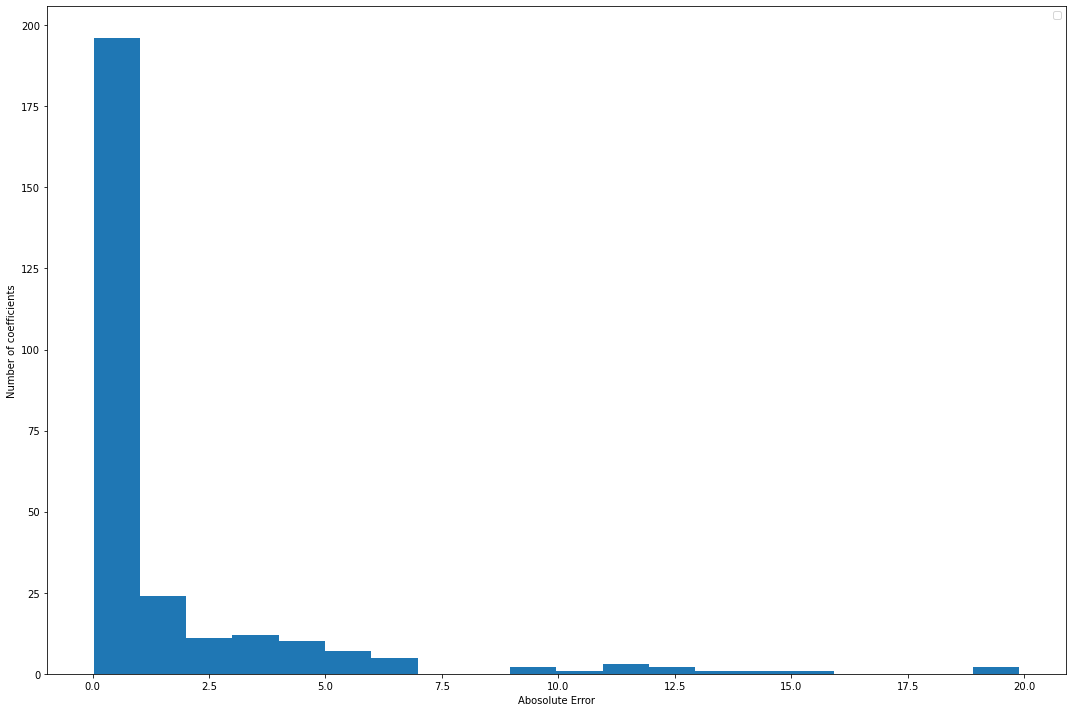

In [140]:
a = error.flatten()
a = a[a < 20]
plot_hist(a, xlabel= 'Abosolute Error', figname=f'Error distribution of the coefficients')

In [108]:
intercept_l = np.array([array([-2.95291883]), array([-2.89353374]), array([-3.55656052]), array([-3.38050763]), array([-3.21683201]), array([-3.54494914]), array([-2.14538487]), array([-3.33804037]), array([-1.06269912]), array([-3.21602606]), array([-2.5269128]), array([-3.4356709]), array([-3.4482794]), array([-2.41308494]), array([-3.30956452]), array([-2.93866427]), array([-3.29240062]), array([-1.88534872]), array([-2.10096403]), array([-1.91338313]), array([-2.30963623]), array([-2.96646752]), array([-3.49770571]), array([-2.89553615]), array([-3.11775328]), array([-3.42342434]), array([-3.06958515]), array([-0.00167468]), array([-3.04044733]), array([-3.30070063]), array([-2.99296621]), array([-2.70900735]), array([-2.81648284]), array([-0.00746212]), array([-3.15353145]), array([-3.26113029]), array([-0.33299378]), array([-3.09137911]), array([-2.15984769]), array([-2.45649579]), array([-3.156661]), array([-2.22107374]), array([-2.90168033]), array([-2.36432563]), array([-2.10685214]), array([-2.73649335]), array([-2.00169189]), array([-3.24813136]), array([0.]), array([-0.62973549]), array([-2.19272681]), array([-3.91298047]), array([-2.5053185]), array([-2.22922473]), array([-1.77510824]), array([-3.07327028])])
coef_l = np.array([array([[-1.41367347e-02,  3.80874191e-02,  1.47716712e-01,
         2.24292617e-04,  4.88092809e-01]]), array([[-1.62803092e-02,  2.82168212e-02,  1.50496185e-01,
         4.45310901e-05,  5.29501642e-01]]), array([[-1.04250206e-02,  3.14707349e-02,  1.82972105e-01,
         2.66437464e-04,  3.93183955e-01]]), array([[-0.01204086,  0.03784418,  0.18399849,  0.00033031,  0.31274546]]), array([[-1.88393184e-02,  4.69083218e-02,  1.78579740e-01,
        -2.22221938e-05,  4.36483424e-01]]), array([[-0.01550586,  0.04901334,  0.17556384,  0.00043578,  0.40298164]]), array([[-0.02688634,  0.04590823,  0.15132083,  0.00031172,  0.28725889]]), array([[-1.45408023e-02,  5.06318567e-02,  1.58099799e-01,
         3.00784283e-04,  5.17719484e-01]]), array([[-0.03973736,  0.02396298,  0.18576577,  0.00026139,  0.11182715]]), array([[-1.86187303e-02,  5.22029106e-02,  1.69218891e-01,
         3.01062313e-04,  3.55022492e-01]]), array([[-0.01612691,  0.0378383 ,  0.17246729,  0.00033231,  0.09581076]]), array([[-1.68239851e-02,  5.15137095e-02,  1.73253137e-01,
         3.44798000e-04,  4.58645185e-01]]), array([[-1.37669351e-02,  3.50041348e-02,  1.81470863e-01,
         2.76062753e-04,  3.93519997e-01]]), array([[-0.02373095,  0.0435327 ,  0.15121564,  0.00057187,  0.31176868]]), array([[-1.43304756e-02,  4.25752812e-02,  1.71218994e-01,
         2.83280980e-04,  4.84852763e-01]]), array([[-2.17115229e-02,  4.24208290e-02,  1.73822752e-01,
         3.19823675e-04,  4.62837336e-01]]), array([[-1.12492812e-02,  4.24992021e-02,  1.45888790e-01,
         1.79209378e-04,  5.27882982e-01]]), array([[-2.28030226e-02,  3.61108666e-02,  1.33702575e-01,
        -3.60405357e-06,  3.70035889e-01]]), array([[-3.23219972e-02,  5.51545777e-02,  1.67054843e-01,
         1.15556734e-04,  2.59483825e-01]]), array([[-4.31524688e-02,  8.41344946e-02,  1.63416763e-01,
         7.51418477e-05,  2.78320189e-01]]), array([[-2.56886613e-02,  4.64895652e-02,  1.51960071e-01,
         5.23495713e-05,  4.25427540e-01]]), array([[-1.99528206e-02,  4.51812899e-02,  1.60090402e-01,
         1.66669736e-04,  5.12817589e-01]]), array([[-5.45832319e-03,  4.28884451e-02,  1.76480435e-01,
        -6.52696608e-05,  2.32116193e-01]]), array([[-1.49189352e-02,  2.50263356e-02,  1.51451425e-01,
         2.09988723e-04,  4.91941026e-01]]), array([[-0.01502059,  0.04242774,  0.15701705,  0.00049235,  0.36810996]]), array([[-0.01233242,  0.0393154 ,  0.16682888,  0.0006454 ,  0.40980726]]), array([[-2.09751946e-02,  5.30045368e-02,  1.68755476e-01,
         3.54579206e-04,  4.46223401e-01]]), array([[-0.01626417,  0.01839327,  0.04935328, -0.00070757,  0.0025515 ]]), array([[-0.01885608,  0.05750488,  0.17879662,  0.00052984,  0.15339196]]), array([[-1.30614238e-02,  5.04070723e-02,  1.55391881e-01,
         3.40955254e-04,  3.64981989e-01]]), array([[-0.0197101 ,  0.04778308,  0.16142618,  0.00054439,  0.36444763]]), array([[-0.01781733,  0.04912245,  0.16163525,  0.00045714,  0.1808141 ]]), array([[-2.22363246e-02,  5.65186018e-02,  1.45875899e-01,
         1.97097560e-04,  3.52364712e-01]]), array([[-0.05285021,  0.04798841,  0.12308677, -0.00075326,  0.0114244 ]]), array([[-0.01616902,  0.04780529,  0.16282311,  0.00087745,  0.31363226]]), array([[-9.36402411e-03,  2.96751070e-02,  1.64201367e-01,
        -7.94248283e-05,  4.08255965e-01]]), array([[-0.04984827,  0.04895229,  0.11960255, -0.0004446 ,  0.28239835]]), array([[-1.35250669e-02,  4.78007702e-02,  1.54975344e-01,
         3.27702670e-04,  4.40055217e-01]]), array([[-0.02340094,  0.01773919,  0.13547141, -0.00099006,  0.65034889]]), array([[-0.01851409,  0.05182574,  0.13580391,  0.00040392,  0.27677855]]), array([[-0.01571097,  0.05926837,  0.15664096,  0.00079383,  0.23242466]]), array([[-2.56303440e-02,  5.61524112e-02,  1.29933887e-01,
        -3.94992057e-04,  4.62230332e-01]]), array([[-1.67823827e-02,  3.99217902e-02,  1.59521430e-01,
         2.97986958e-04,  4.44452594e-01]]), array([[-0.02915151,  0.05056271,  0.17033991,  0.0003071 ,  0.27992992]]), array([[-0.03059831,  0.07060066,  0.15042849, -0.00115839,  0.23783674]]), array([[-0.00980248,  0.05175754,  0.15366447,  0.00045604,  0.1851195 ]]), array([[-2.79436068e-02,  6.24146663e-02,  1.32308957e-01,
        -2.54064831e-04,  4.18677743e-01]]), array([[-0.00696753,  0.04921902,  0.16601031,  0.00060281,  0.19266306]]), array([[-0.00402843,  0.        ,  0.02388564,  0.00025645,  0.        ]]), array([[-0.08434883,  0.04992097,  0.09566007,  0.00305911,  1.1571078 ]]), array([[-2.55873897e-02,  4.89243635e-02,  1.26009539e-01,
         1.91584008e-04,  4.61405687e-01]]), array([[-1.04386135e-02,  4.54822605e-02,  1.88816897e-01,
         2.06887123e-04,  4.28588762e-01]]), array([[-2.45084100e-02,  5.22678797e-02,  1.41112191e-01,
         2.99182996e-04,  4.96171709e-01]]), array([[-2.22190572e-02,  5.44442198e-02,  1.37977085e-01,
         3.78445162e-05,  4.44679760e-01]]), array([[-2.70797221e-02,  3.76781463e-02,  1.28263628e-01,
        -1.63184509e-04,  4.43036953e-01]]), array([[-0.01492703,  0.03600221,  0.15149321,  0.00058832,  0.52205352]])])

In [121]:
print(np.shape(coef_l[:,:,5]))

IndexError: index 5 is out of bounds for axis 2 with size 5

No handles with labels found to put in legend.


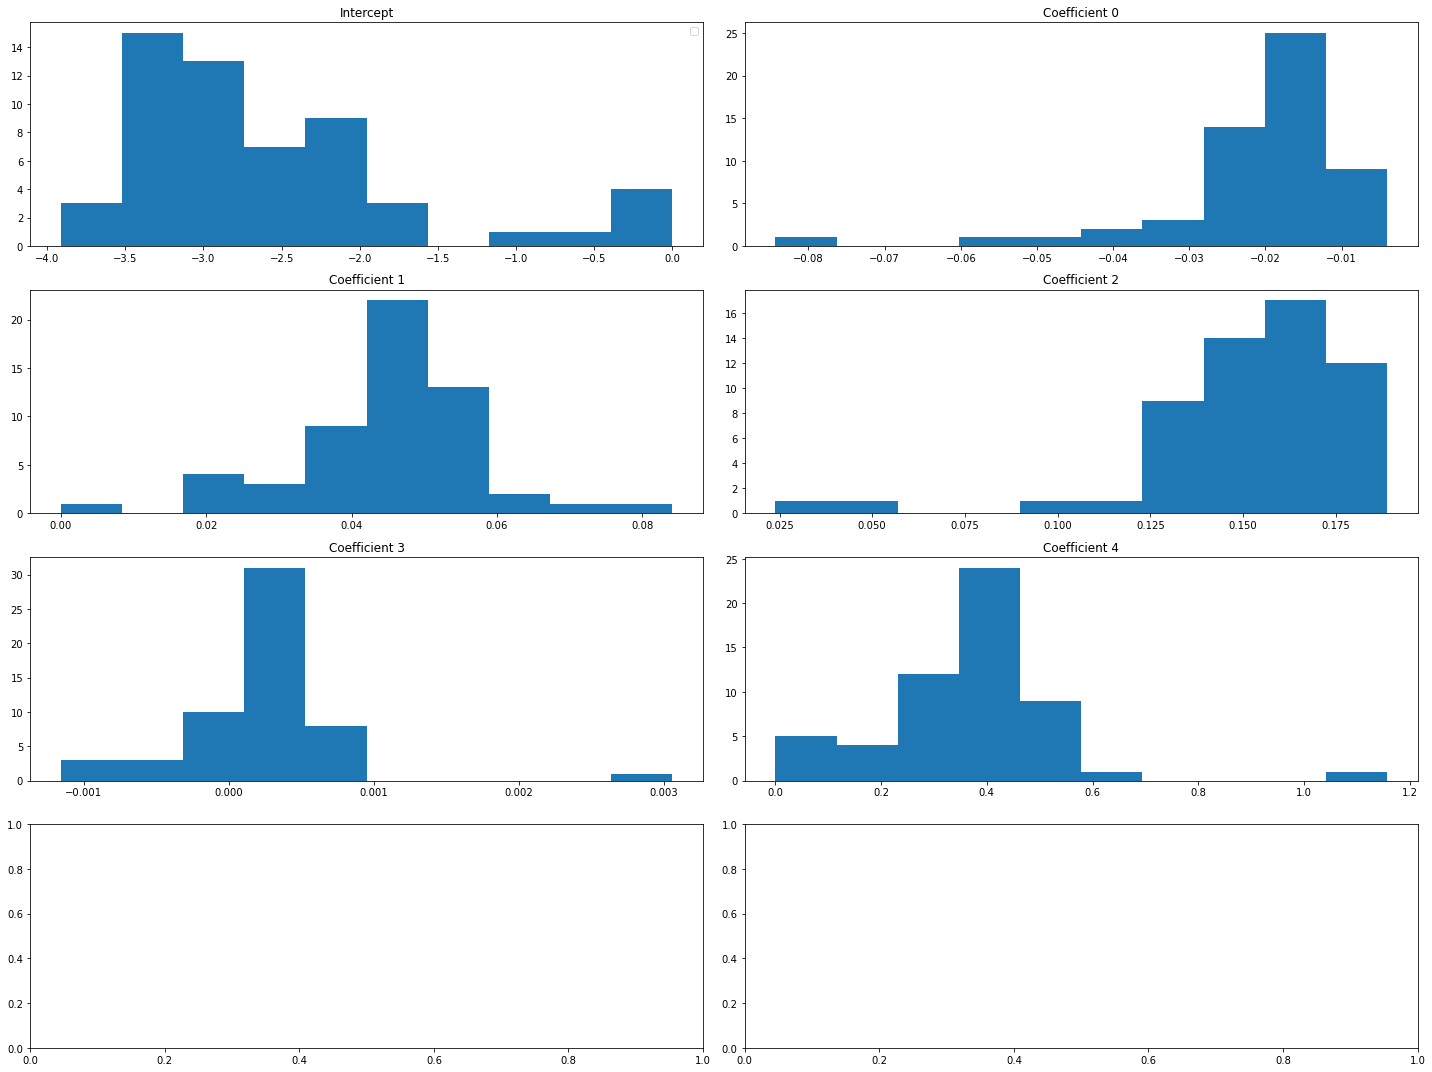

In [131]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5),(ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(20,15))

colors = ['red', 'tan', 'lime']
ax0.hist(intercept_l, n_bins, density=False, histtype='bar')#, color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('Intercept')

ax1.hist(coef_l[:,:,0], n_bins, density=False, histtype='bar')
ax1.set_title('Coefficient 0')

ax2.hist(coef_l[:,:,1], n_bins, density=False, histtype='bar')
ax2.set_title('Coefficient 1')

ax3.hist(coef_l[:,:,2], n_bins, density=False, histtype='bar')
ax3.set_title('Coefficient 2')

ax4.hist(coef_l[:,:,3], n_bins, density=False, histtype='bar')
ax4.set_title('Coefficient 3')
#ax4.set_xlim([-1,1])

ax5.hist(coef_l[:,:,4], n_bins, density=False, histtype='bar')
ax5.set_title('Coefficient 4')
#ax5.set_xlim([-1,1])


fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


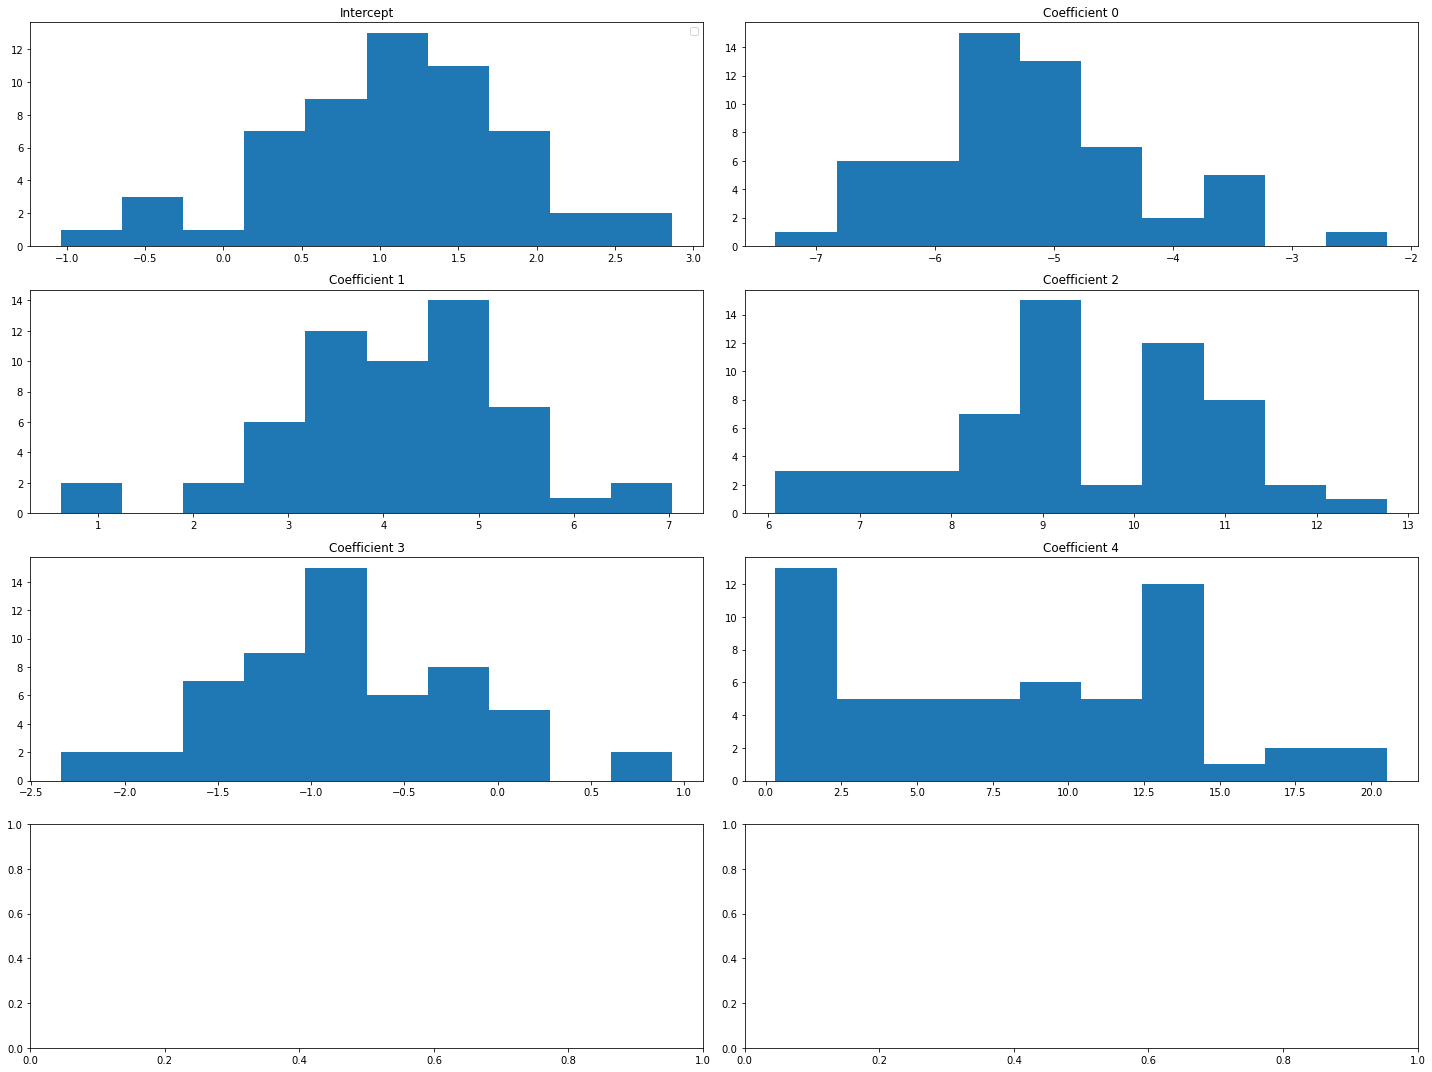

In [132]:
intercept_l = np.array([array([1.41166305]), array([0.49314751]), array([1.82301233]), array([1.35900513]), array([2.15408251]), array([1.76271734]), array([2.0104497]), array([2.86649155]), array([1.39490666]), array([0.99682581]), array([0.31411773]), array([1.34150505]), array([1.42038632]), array([0.67752146]), array([1.50428133]), array([1.71799887]), array([1.23939513]), array([1.31783761]), array([2.17847566]), array([1.08156985]), array([1.84326593]), array([0.97085333]), array([0.78218743]), array([1.61694662]), array([0.77613503]), array([1.21673312]), array([0.68226542]), array([-1.03884462]), array([1.06213971]), array([1.05349376]), array([1.13416497]), array([0.94303878]), array([0.54512575]), array([2.54732446]), array([0.7515886]), array([-0.25820929]), array([2.0001421]), array([1.122153]), array([-0.27319614]), array([0.46755343]), array([0.13327208]), array([0.30696797]), array([0.9578501]), array([0.04109376]), array([-0.4468961]), array([1.24227637]), array([1.40537611]), array([0.85537737]), array([1.36182067]), array([1.44970943]), array([0.21840497]), array([0.99745584]), array([0.30433192]), array([0.63806133]), array([0.68756817]), array([1.92016358])])
coef_l =  np.array([array([[-4.45933712,  3.01521226,  7.98189986, -1.12080376,  3.81393013]]), array([[-3.71020381,  3.03936295,  6.86486774, -0.14919135,  1.18988373]]), array([[-5.96470497,  3.56691752, 10.23224747, -1.59530216, 13.64478263]]), array([[-5.4748932 ,  3.3884347 ,  9.63195803, -1.10755514, 13.31670706]]), array([[-6.41459841,  3.95567247, 10.95236246, -1.83627126,  9.63976509]]), array([[-5.94142   ,  3.65063417, 10.67288483, -1.60256382, 11.34096319]]), array([[-6.28501396,  3.98617753,  9.36368986, -1.54556124, 13.92986482]]), array([[-7.3414269 ,  3.72813883,  9.38892424, -2.31477088, 20.52614808]]), array([[-4.33479858,  0.60752603,  8.88436631, -0.90596955,  1.03027706]]), array([[-5.53543749,  4.3040412 , 10.18433607, -0.79609989, 11.82233578]]), array([[-4.91013303,  4.6302328 , 10.25711957, -0.08099732,  6.55059259]]), array([[-6.41047353,  5.03830495, 10.80286126, -1.2134978 , 17.92357723]]), array([[-5.75029568,  3.51983675, 11.27714412, -1.19581787,  5.00664559]]), array([[-5.00008366,  3.46260741,  9.34428363, -0.232258  ,  3.86641437]]), array([[-5.39120998,  3.73923463, 10.24760112, -1.21560541,  6.14995475]]), array([[-6.3723127 ,  4.22116048, 12.7686076 , -1.61080838, 15.20009868]]), array([[-5.45641161,  4.14720686,  8.58562319, -0.93755463, 14.4027635 ]]), array([[-5.05457723,  3.46519878,  8.8978085 , -1.11108364, 13.73792426]]), array([[-6.54002429,  4.52687271, 11.98752955, -1.99328246,  3.39906648]]), array([[-3.39346969,  2.28382487,  6.07740611, -0.91808655,  0.31616212]]), array([[-6.47355609,  4.70459955, 11.13958905, -1.59002802, 14.29534335]]), array([[-5.50299632,  3.75823355, 10.78442809, -0.7947285 , 13.9566322 ]]), array([[-4.46851025,  3.72355674, 11.41247913, -0.94532692,  0.73721318]]), array([[-5.29051794,  2.60734641,  8.21714918, -1.21121907, 12.16778844]]), array([[-5.13109092,  4.21621346,  9.06661151, -0.67544183, 13.66330261]]), array([[-5.30478823,  3.9398641 ,  9.40690072, -1.03191984,  5.2423274 ]]), array([[-5.50775678,  5.20295433, 11.05573653, -0.53431772, 10.34807246]]), array([[-2.20308204,  3.01594169,  7.12113764,  0.93680673,  1.68228543]]), array([[-5.81822275,  4.24403854, 11.6663896 , -1.02806555, 12.71922321]]), array([[-5.34569028,  4.69081645,  8.87851189, -0.89559633,  9.84350516]]), array([[-5.73486198,  4.48162199, 10.62685434, -0.98140255,  8.80023264]]), array([[-5.69904142,  5.22019269, 10.56031302, -0.80984699, 11.27743279]]), array([[-4.90033034,  5.46449432,  7.33688368, -0.5616613 ,  5.19947367]]), array([[-5.00210086,  0.73254425,  8.56030263, -2.34272295,  1.49544709]]), array([[-4.66041874,  3.99593161,  9.33633106, -0.45752377,  1.52901264]]), array([[-3.68372272,  3.89237928, 10.55250916,  0.16086353,  7.53207278]]), array([[-5.69472724,  2.78329079,  8.82356039, -1.40812126,  1.70678083]]), array([[-5.56367599,  4.75465155, 10.52660675, -0.99493853, 12.78197414]]), array([[-4.07427227,  4.46853755,  8.53185953,  0.64533472,  3.85188005]]), array([[-5.11689294,  4.86057063, 10.21851578, -0.32740777,  6.83188932]]), array([[-4.99519966,  6.15644509,  9.00384322, -0.08970987, 10.14554664]]), array([[-4.47622603,  4.74386752,  9.05177486, -0.25327394,  7.25255947]]), array([[-5.45181858,  4.63027057, 10.61189803, -0.77419296, 11.93870485]]), array([[-3.54008244,  3.49641489,  8.62307174, -0.04387444,  0.72135804]]), array([[-4.63882292,  6.94581198,  9.4196414 ,  0.1044283 ,  2.8145948 ]]), array([[-6.10684046,  7.03899749, 10.97746656, -0.98735584,  8.04912041]]), array([[-4.06830295,  3.13589406,  6.48515242, -1.08822322,  0.69028644]]), array([[-5.2109303 ,  5.22190167,  8.27727054, -0.30214662,  1.14780293]]), array([[-4.89849325,  5.16796087,  8.09248147, -0.99038189,  0.85012264]]), array([[-6.15200856e+00,  4.79100451e+00,  6.51127626e+00,
         2.07194131e-03,  6.68913360e-01]]), array([[-4.88269704e+00,  5.02173895e+00,  7.53400962e+00,
         2.56841170e-03,  1.90129326e+01]]), array([[-5.06679264,  5.25806307, 10.59066339, -1.02625137, 13.04860403]]), array([[-4.99383515,  5.28998953,  9.0043816 , -0.12940191, 12.8154998 ]]), array([[-4.59706366,  5.0171997 ,  9.7457764 , -0.54233451,  8.46171808]]), array([[-3.3247043 ,  2.148743  ,  7.4728036 , -0.64629149,  5.7597993 ]]), array([[-6.44576105,  3.63836415,  9.26900842, -1.46107097, 17.31845781]])])


import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5),(ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(20,15))

colors = ['red', 'tan', 'lime']
ax0.hist(intercept_l, n_bins, density=False, histtype='bar')#, color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('Intercept')

ax1.hist(coef_l[:,:,0], n_bins, density=False, histtype='bar')
ax1.set_title('Coefficient 0')

ax2.hist(coef_l[:,:,1], n_bins, density=False, histtype='bar')
ax2.set_title('Coefficient 1')

ax3.hist(coef_l[:,:,2], n_bins, density=False, histtype='bar')
ax3.set_title('Coefficient 2')

ax4.hist(coef_l[:,:,3], n_bins, density=False, histtype='bar')
ax4.set_title('Coefficient 3')
#ax4.set_xlim([-1,1])

ax5.hist(coef_l[:,:,4], n_bins, density=False, histtype='bar')
ax5.set_title('Coefficient 4')
#ax5.set_xlim([-1,1])


fig.tight_layout()
plt.show()